## Import Libraries

In [2]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import seaborn as sns
from collections import deque
import matplotlib.pyplot as plt


%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, Dense, Conv2D, TimeDistributed, Flatten, GRU, Dropout, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

### Convert Raw video datasets into a 320x240 at 30fps

In [ ]:
def downgrade_video_quality(input_folder, output_folder, target_width=320, target_height=240, target_fps=30):
    """
    Downgrades the quality of videos in a given folder and organizes them by exercise name.

    Args:
        input_folder: The path to the folder containing the raw videos.
        output_folder: The path to the folder where the downgraded videos will be saved.
        target_width: The desired width of the output videos.
        target_height: The desired height of the output videos.
        target_fps:  The desired frames per second.  Crucially, get from the original.
    """

    # Create the output folder and subfolders if they don't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for exercise_name in os.listdir(input_folder):
        exercise_path = os.path.join(input_folder, exercise_name)

        # Check if it's a directory (to avoid processing non-directory files)
        if os.path.isdir(exercise_path):
            output_exercise_path = os.path.join(output_folder, exercise_name)
            if not os.path.exists(output_exercise_path):
                os.makedirs(output_exercise_path)

            for filename in os.listdir(exercise_path):
                if filename.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):  # Add more extensions if needed
                    input_filepath = os.path.join(exercise_path, filename)
                    output_filepath = os.path.join(output_exercise_path, filename)

                    try:
                        # Open the video file
                        video_capture = cv2.VideoCapture(input_filepath)

                        # Check if video opened successfully
                        if not video_capture.isOpened():
                            print(f"Error: Could not open video {input_filepath}")
                            continue

                        # Get original video properties
                        original_fps = video_capture.get(cv2.CAP_PROP_FPS)
                        # original_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)) #Not used
                        # original_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT)) #Not used
                        
                        # Use the original FPS if target_fps is not specified or is invalid
                        fps_to_use = original_fps if original_fps > 0 else target_fps

                        # Define the codec and create VideoWriter object
                        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'XVID' for AVI, or other codecs as needed
                        out = cv2.VideoWriter(output_filepath, fourcc, fps_to_use, (target_width, target_height))


                        while True:
                            ret, frame = video_capture.read()
                            if not ret:
                                break  # End of video

                            # Resize the frame
                            resized_frame = cv2.resize(frame, (target_width, target_height))

                            # Write the resized frame to the output video
                            out.write(resized_frame)

                        # Release resources
                        video_capture.release()
                        out.release()
                        print(f"Processed: {input_filepath} -> {output_filepath}")

                    except Exception as e:
                        print(f"Error processing {input_filepath}: {e}")

    print("Video processing complete.")



if __name__ == '__main__':
    raw_folder = "raw"  # Replace with the actual path to your raw videos folder
    downgraded_folder = "downgraded_raw"  # The output folder

    downgrade_video_quality(raw_folder, downgraded_folder)

### Set Numpy, Python, and TF seeds

In [3]:
spatial_input_size = (224,224,3)
temporal_input_size = (320, 240, 1)

In [4]:

seed_constant = 7
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

batch_size = 8 # Change this shit pag sasabog na yung GPU

## Visualize Data for 1st CNN stream


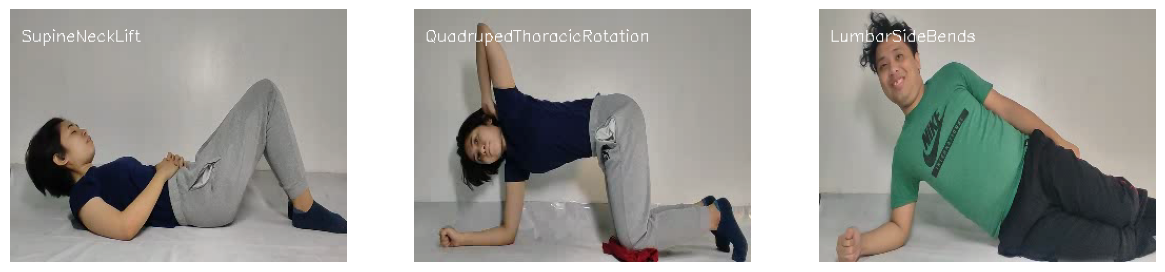

In [5]:
plt.figure(figsize = (20,20))

all_class_names = os.listdir('downgraded_raw')

random_range = random.sample(range(len(all_class_names)), 3)

for counter, random_index in enumerate(random_range, 1):
    selected_class_name = all_class_names[random_index]

    video_files_names_list = os.listdir(f'downgraded_raw/{selected_class_name}') 
    selected_video_file_name =  random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'downgraded_raw/{selected_class_name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()
    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255),1)

    plt.subplot(5,4, counter);plt.imshow(rgb_frame);plt.axis('off')


## PreProcess the Dataset

In [6]:
IMAGE_HEIGHT, IMAGE_WIDTH =  64, 64

SEQUENCE_LENGTH = 20

DATASET_DIR = r"/Users/patrickpadua/Downloads/Yango RRL/CSV Generator/CNN_GRU_usingRGBOF/downgraded_raw"

CLASSES_LIST = ['LumbarSideBends','QuadrupedThoracicRotation','SupineNeckLift']
num_classes = len(CLASSES_LIST)

## Extraction of Features 

1st Stream

In [7]:
def frames_extraction(video_path):
    """Extract frames from video and return normalized RGB frames"""
    frames_list1 = []
    
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        
        success, frame = video_reader.read()
        
        if not success:
            break
        
        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Resize and normalize
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame/255
        
        frames_list1.append(normalized_frame)
    
    video_reader.release()
    
    while len(frames_list1) < SEQUENCE_LENGTH:
        frames_list1.append(np.zeros_like(frames_list1[-1]))
    
    return frames_list1

2nd CNN Stream

###### Get optical flow frames

In [8]:
def compute_optical_flow(prev_frame, next_frame):
    # Convert frames to grayscale
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(21, 21), maxLevel=3, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    # Detect good features to track (Shi-Tomasi corners)
    feature_params = dict(maxCorners=3000, qualityLevel=0.01, minDistance=0.1)
    p0 = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)

    # Calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, next_gray, p0, None, **lk_params)

    # Select good points
    if p1 is not None:
        good_new = p1[st == 1]
        good_old = p0[st == 1]
    else:
        good_new, good_old = [], []

    return good_old, good_new

def create_mei_mhi(flow, shape, tau=10):
    # Initialize MEI and MHI
    mei = np.zeros(shape, dtype=np.float32)  # Binary motion energy
    mhi = np.zeros(shape, dtype=np.float32)  # Motion history with decay

    # Update MEI and MHI
    for (new, old) in zip(flow[1], flow[0]):
        x1, y1 = new.ravel()
        x2, y2 = old.ravel()
        
        # Draw motion on MEI (binary)
        cv2.line(mei, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)
        
        # Draw motion on MHI (with intensity based on time)
        cv2.line(mhi, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)

    # Update MHI with decay
    mhi[mhi > 0] -= 255 / tau  # Decay over time
    mhi[mhi < 0] = 0  # Ensure no negative values

    return mei, mhi

In [9]:
def compute_optical_flow(prev_frame, next_frame):
    # Convert frames to grayscale
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(21, 21), maxLevel=3, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    # Detect good features to track (Shi-Tomasi corners)
    feature_params = dict(maxCorners=3000, qualityLevel=0.01, minDistance=0.1)
    p0 = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)

    # Calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, next_gray, p0, None, **lk_params)

    # Select good points
    if p1 is not None:
        good_new = p1[st == 1]
        good_old = p0[st == 1]
    else:
        good_new, good_old = [], []

    return good_old, good_new

def create_mei_mhi(flow, shape, tau=10):
    # Initialize MEI and MHI
    mei = np.zeros(shape, dtype=np.float32)  # Binary motion energy
    mhi = np.zeros(shape, dtype=np.float32)  # Motion history with decay

    # Update MEI and MHI
    for (new, old) in zip(flow[1], flow[0]):
        x1, y1 = new.ravel()
        x2, y2 = old.ravel()
        
        # Draw motion on MEI (binary)
        cv2.line(mei, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)
        
        # Draw motion on MHI (with intensity based on time)
        cv2.line(mhi, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)

    # Update MHI with decay
    mhi[mhi > 0] -= 255 / tau  # Decay over time
    mhi[mhi < 0] = 0  # Ensure no negative values

    return mei, mhi

def frames_extraction_OF(video_path, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH):
    # Initialize frames list to store MEI images
    frames_list2 = []

    # Open the video
    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        print(f"Error: Could not open video {video_path}.")
        return frames_list2

    # Get total number of frames in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate through the video frames
    for frame_counter in range(0, video_frames_count - skip_frames_window, skip_frames_window):
        # Set the previous frame position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)
        success, prev_frame = video_reader.read()
        if not success:
            break

        # Set the next frame position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter + skip_frames_window)
        success, next_frame = video_reader.read()
        if not success:
            break

        # Resize frames to the desired dimensions
        prev_frame_resized = cv2.resize(prev_frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        next_frame_resized = cv2.resize(next_frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Compute optical flow between the previous and next frame
        good_old, good_new = compute_optical_flow(prev_frame_resized, next_frame_resized)

        # Check if optical flow computation was successful
        if len(good_old) == 0 or len(good_new) == 0:
            print(f"Warning: No optical flow vectors found for frames {frame_counter} and {frame_counter + skip_frames_window}.")
            continue

        # Create MEI (Motion Energy Image)
        mei, _ = create_mei_mhi((good_old, good_new), (IMAGE_HEIGHT, IMAGE_WIDTH), tau=10)

        # Normalize MEI for better visualization
        mei_norm = cv2.normalize(mei, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        # Add a channel dimension to the MEI image
        mei_norm = np.expand_dims(mei_norm, axis=-1)

        # Append the MEI to the frames list
        frames_list2.append(mei_norm)

    # Release the video reader
    video_reader.release()

    # Pad the frames list with zeros if it has fewer frames than SEQUENCE_LENGTH
    while len(frames_list2) < SEQUENCE_LENGTH:
        frames_list2.append(np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.uint8))

    # Convert the list of frames to a 4D numpy array
    frames_list2 = np.stack(frames_list2, axis=0)

    return frames_list2

## Dataset Creation

1st Stream

In [10]:
def create_dataset_1st():
    """Creates the dataset with only flipping and rotation augmentations"""
    features1 = []
    labels1 = []
    video_files_paths1 = []
    
    # Create ImageDataGenerator with only rotation and flipping
    datagen = ImageDataGenerator(
        rotation_range=15,        # Up to 15 degrees rotation
        horizontal_flip=True,     # Horizontal flipping
        fill_mode='nearest'       # How to fill points outside the input boundaries
    )
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of class: {class_name}')
        
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            
            try:
                # Extract original frames
                frames = frames_extraction(video_file_path)
                
                if len(frames) == SEQUENCE_LENGTH:
                    # Add original frames
                    features1.append(frames)
                    labels1.append(class_index)
                    video_files_paths1.append(video_file_path)
                    
                    # Generate augmented version with rotation and/or flip
                    augmented_frames = []
                    seed = np.random.randint(1000)  # Use same seed for all frames in sequence
                    
                    for frame in frames:
                        frame_expanded = np.expand_dims(frame, 0)
                        it = datagen.flow(frame_expanded, batch_size=1, seed=seed)
                        augmented_frame = next(it)[0]
                        augmented_frames.append(augmented_frame)
                    
                    features1.append(augmented_frames)
                    labels1.append(class_index)
                    video_files_paths1.append(video_file_path + '_aug')
            
            except Exception as e:
                print(f"Warning: Processing failed for {video_file_path}: {str(e)}")
                continue
    
    features1 = np.array(features1)
    labels1 = np.array(labels1)
    
    return features1, labels1, video_files_paths1

In [11]:
features1, labels1, video_files_paths1 = create_dataset_1st()
    

print(f"Features shape: {features1.shape}")
print(f"Labels shape: {labels1.shape}")
print(f"Number of videos (including augmented): {len(video_files_paths1)}")

Extracting Data of class: LumbarSideBends
Extracting Data of class: QuadrupedThoracicRotation
Extracting Data of class: SupineNeckLift
Features shape: (420, 20, 64, 64, 3)
Labels shape: (420,)
Number of videos (including augmented): 420


In [12]:
#convert labels into one-hot encoded vectors
one_hot_encoded_labels1 = to_categorical(labels1)

In [13]:
# Display the converted labels
unique_labels1, counts1 = np.unique(labels1, return_counts=True)
for label, count in zip(unique_labels1, counts1):
    print(f"Label {label}: {count} instances")

Label 0: 140 instances
Label 1: 140 instances
Label 2: 140 instances


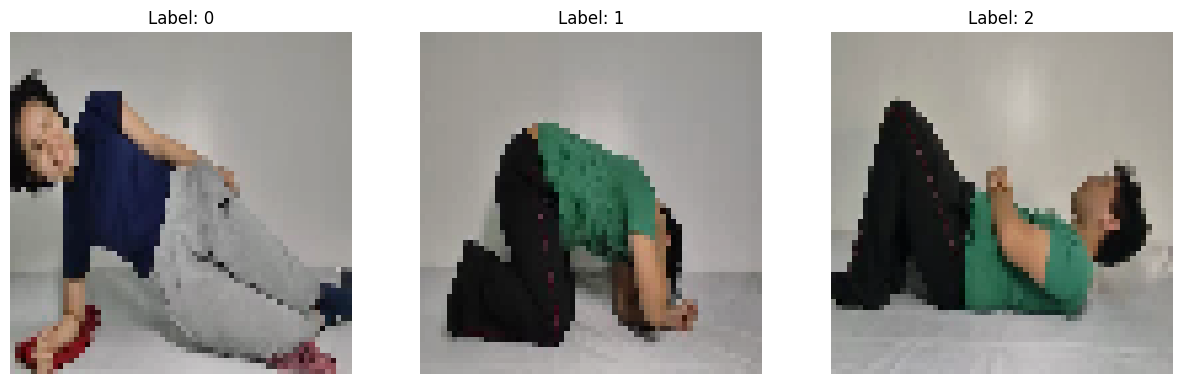

In [14]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

for i, label in enumerate(unique_labels1):
    # Find the first index of the current label
    index = np.where(labels1 == label)[0][0]

#Extract the corresponding video frames
    frames = features1[index]

#Select a random frame instead of the middle one
    random_frame = frames[np.random.randint(0, len(frames))]

#Plot the frame
    plt.subplot(1, 3, i + 1)
    plt.imshow(random_frame)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

2nd Stream

In [15]:
def create_dataset_2nd():
    """Creates the dataset with only flipping and rotation augmentations"""
    features2 = []
    labels2 = []
    video_files_paths2 = []
    
    # Create ImageDataGenerator with only rotation and flipping
    datagen = ImageDataGenerator(
        rotation_range=15,        # Up to 15 degrees rotation
        horizontal_flip=True,     # Horizontal flipping
        fill_mode='nearest'       # How to fill points outside the input boundaries
    )
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of class: {class_name}')
        
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            
            try:
                # Extract original frames
                frames = frames_extraction_OF(video_file_path, SEQUENCE_LENGTH, 320, 240)
                
                if len(frames) == SEQUENCE_LENGTH:
                    # Add original frames
                    features2.append(frames)
                    labels2.append(class_index)
                    video_files_paths2.append(video_file_path)
                    
                    # Generate augmented version with rotation and/or flip
                    augmented_frames = []
                    seed = np.random.randint(1000)  # Use same seed for all frames in sequence
                    
                    for frame in frames:
                        frame_expanded = np.expand_dims(frame, 0)
                        it = datagen.flow(frame_expanded, batch_size=1, seed=seed)
                        augmented_frame = next(it)[0]
                        augmented_frames.append(augmented_frame)
                    
                    features2.append(augmented_frames)
                    labels2.append(class_index)
                    video_files_paths2.append(video_file_path + '_aug')
            
            except Exception as e:
                print(f"Warning: Processing failed for {video_file_path}: {str(e)}")
                continue
    
    features2 = np.array(features2)
    labels2 = np.array(labels2)
    
    return features2, labels2, video_files_paths2

In [16]:
features2, labels2, video_files_paths2 = create_dataset_2nd()
    

print(f"Features shape: {features2.shape}")
print(f"Labels shape: {labels2.shape}")
print(f"Number of videos (including augmented): {len(video_files_paths2)}")

Extracting Data of class: LumbarSideBends
Extracting Data of class: QuadrupedThoracicRotation
Extracting Data of class: SupineNeckLift
Features shape: (350, 20, 320, 240, 1)
Labels shape: (350,)
Number of videos (including augmented): 350


In [17]:
#convert labels into one-hot encoded vectors
one_hot_encoded_labels2 = to_categorical(labels2)

In [18]:
# Display the converted labels 
unique_labels2, counts2 = np.unique(labels2, return_counts=True)
for label, count in zip(unique_labels2, counts2):
    print(f"Label {label}: {count} instances")

Label 0: 116 instances
Label 1: 114 instances
Label 2: 120 instances


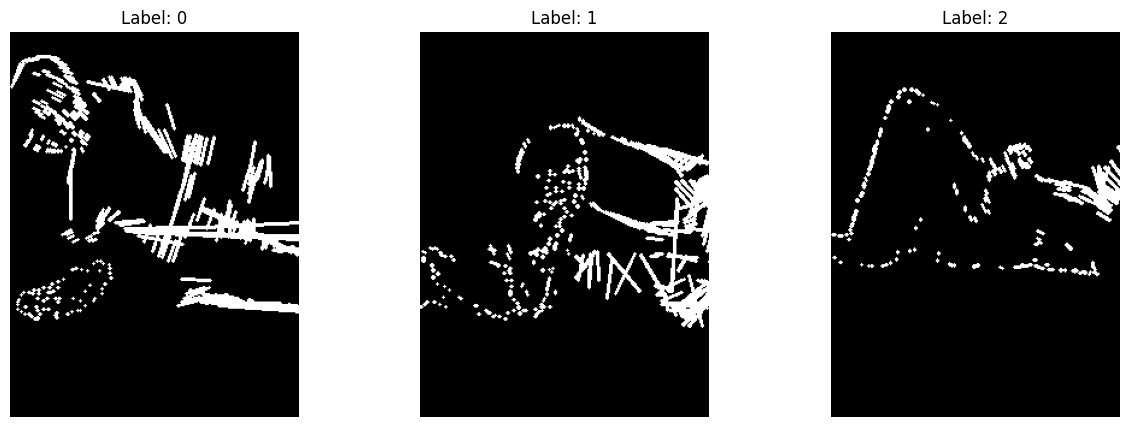

In [19]:
plt.figure(figsize=(15, 5))

for i, label in enumerate(unique_labels2):
    # Find the first index of the current label
    index = np.where(labels2 == label)[0][0]

#Extract the corresponding video frames
    frames = features2[index]

#Select a random frame instead of the middle one
    random_frame = frames[np.random.randint(0, len(frames))]

#Plot the frame
    plt.subplot(1, 3, i + 1)
    plt.imshow(random_frame, cmap="grey")
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

## Split Data into Train, Test, and Validation

For 1st Stream (RBG Data)

In [20]:
features_train1, features_test1, labels_train1, labels_test1 = train_test_split(features1, one_hot_encoded_labels1,
                                                                                test_size=0.20, shuffle = True, 
                                                                                random_state = seed_constant)
features_train1, features_val1, labels_train1, labels_val1 = train_test_split(
    features_train1, labels_train1, test_size=0.20, shuffle=True, random_state=seed_constant
)

# Display the number of samples in each set
print(f"Number of training samples: {len(features_train1)}")
print(f"Number of validation samples: {len(features_val1)}")
print(f"Number of testing samples: {len(features_test1)}")


Number of training samples: 268
Number of validation samples: 68
Number of testing samples: 84


For 2nd Stream (OF Data)

In [21]:
features_train2, features_test2, labels_train2, labels_test2 = train_test_split(features2, one_hot_encoded_labels2,
                                                                                test_size=0.20, shuffle = True, 
                                                                                random_state = seed_constant)
features_train2, features_val2, labels_train2, labels_val2 = train_test_split(
    features_train2, labels_train2, test_size=0.20, shuffle=True, random_state=seed_constant
)

# Display the number of samples in each set
print(f"Number of training samples: {len(features_train2)}")
print(f"Number of validation samples: {len(features_val2)}")
print(f"Number of testing samples: {len(features_test2)}")

Number of training samples: 224
Number of validation samples: 56
Number of testing samples: 70


## Implement 2stream Model

In [51]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout  # Added LeakyReLU
from tensorflow.keras.models import Model

In [22]:
# Define input shapes
input_shape_rgb = (labels1.shape)  # (Time steps, Height, Width, Channels)
of_input_shape = (labels2.shape)   # (Time steps, Height, Width, OF Channels)
num_classes = 3 # Example: 10 action classes

SEQUENCE_LENGTH = 20
IMAGE_HEIGHT_RGB = 64
IMAGE_WIDTH_RGB = 64

In [53]:
print(rgb_input_shape)
print(of_input_shape)

NameError: name 'rgb_input_shape' is not defined

## Define the Transfer learning model


### RGB

In [54]:
from tensorflow.keras.applications import MobileNetV2  # Import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

In [58]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense
import tensorflow as tf

# Load the MobileNet V3 Small model with pre-trained ImageNet weights
mobilenet_v3_small = MobileNetV3Small(
    include_top=False, 
    weights='imagenet', 
    input_shape=spatial_input_size,  # model_input_size should be (224, 224, 3) as per your current setup
    pooling='avg'  # Use global average pooling
)

# Freeze the base model to prevent training its weights
mobilenet_v3_small.trainable = False

# Show the summary of the base model
mobilenet_v3_small.summary()

# Add custom layers on top of MobileNet V3 Small
x = mobilenet_v3_small.output
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dense(1024, activation='relu')(x)  # Connected to the previous dense layer
output = Dense(len(CLASSES_LIST), activation='softmax')(x)  # Output layer based on the number of exercise types

# Define the new model
model = tf.keras.Model(inputs=mobilenet_v3_small.input, outputs=output)

# Show the summary of the final model
model.summary()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adjust learning rate as needed
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                   

Define the RGB CNN Architecture

In [57]:
num_classes = 3  # Replace with the actual number of your classes
input_shape_rgb = (224, 224, 3)  # The desired input shape

rgb_model = mobilenet_v3_small(num_classes, input_shape_rgb)


ValueError: Exception encountered when calling layer "MobilenetV3small" "                 f"(type Functional).

Input 0 of layer "Conv" is incompatible with the layer: expected min_ndim=4, found ndim=0. Full shape received: ()

Call arguments received by layer "MobilenetV3small" "                 f"(type Functional):
  • inputs=tf.Tensor(shape=(), dtype=int32)
  • training=('224', '224', '3')
  • mask=None

In [59]:
rgb_model.summary()

NameError: name 'rgb_model' is not defined

Define the Optical Flow CNN architecture

In [60]:
def create_flow_stream(input_shape, name='flow_stream'):
    """Creates the optical flow stream using custom CNN"""
    inputs = Input(shape=input_shape)
    
    # First block
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Second block
    x = Conv2D(128, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Third block
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Global features
    x = GlobalAveragePooling2D()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.5)(x)
    
    return Model(inputs=inputs, outputs=x, name=name)

In [61]:
optical_flow_model = create_flow_stream(input_shape=temporal_input_size)  # Corrected call

In [62]:
optical_flow_model.summary()

Model: "flow_stream"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 320, 240, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 160, 120, 64)      3200      
                                                                 
 batch_normalization (BatchN  (None, 160, 120, 64)     256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 160, 120, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 60, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 60, 128)       

##### My version

In [74]:
def create_two_stream_model(rgb_model, flow_model, num_classes):
    """
    Creates a two-stream model by combining RGB and optical flow models.
    
    Args:
        rgb_model: Pre-trained RGB model
        flow_model: Pre-trained optical flow model
        num_classes: Number of output classes
    
    Returns:
        A compiled two-stream Keras model
    """
    # Get the input shapes from both models
    rgb_input = Input(shape=rgb_model.input_shape[1:], name='rgb_input')
    flow_input = Input(shape=flow_model.input_shape[1:], name='flow_input')
    
    # Get features from both streams (remove the last layer from RGB model)
    rgb_features = rgb_model.layers[-2].output
    flow_features = flow_model.output
    
    # Create new Model that outputs features for RGB
    rgb_feature_model = Model(inputs=rgb_model.input, outputs=rgb_features)
    
    # Connect the inputs to the feature extractors
    rgb_stream = rgb_feature_model(rgb_input)
    flow_stream = flow_model(flow_input)
    
    # Combine features
    combined = Concatenate()([rgb_stream, flow_stream])
    
    # Add fusion layers
    x = Dense(512, activation='relu')(combined)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create the full model
    model = Model(
        inputs=[rgb_input, flow_input],
        outputs=outputs,
        name='two_stream_model'
    )
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [75]:
two_stream_model = create_two_stream_model(rgb_model, optical_flow_model, num_classes)

In [76]:
two_stream_model.summary()

Model: "two_stream_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rgb_input (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 flow_input (InputLayer)        [(None, 320, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_4 (Functional)           (None, 512)          2054768     ['rgb_input[0][0]']              
                                                                                   

In [62]:
def create_2stream_model():
    # Input layers
    input_rgb = Input(shape=rgb_input_shape)
    input_of = Input(shape=of_input_shape)

    # CNN models
    rgb_cnn_model = create_rgb_cnn_architecture()
    of_cnn_model = create_optical_flow_cnn_architecture()

    # TimeDistributed CNNs (Frame-wise feature extraction)
    rgb_features_sequence = TimeDistributed(rgb_cnn_model)(input_rgb)
    of_features_sequence = TimeDistributed(of_cnn_model)(input_of)

    # GRU layers
    rgb_gru_output = GRU(units=128)(rgb_features_sequence)  # Example GRU units
    of_gru_output = GRU(units=128)(of_features_sequence)    # Example GRU units

    # Fusion (Late Fusion - Concatenate)
    merged_features = Concatenate()([rgb_gru_output, of_gru_output])

    # Classification layers
    dense_layer = Dense(units=256, activation='relu')(merged_features)
    output_layer = Dense(units=num_classes, activation='softmax')(dense_layer)

    # Create the 2-Stream Model
    model = Model(inputs=[input_rgb, input_of], outputs=output_layer)
    # Model Summary
    model.summary()
    
    return model

### Training

Training for Optical Flow


Preprocessing data...
Processed training data shape: (224, 20, 160, 120, 1)
Model: "two_stream_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 160, 120, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 20, 80, 60, 32)    2432      
                                                                 
 batch_normalization (BatchN  (None, 20, 80, 60, 32)   128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 20, 80, 60, 32)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 40, 30, 32)   0         
 )                                      

2025-02-10 00:29:40.602443: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14/14 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.7232
Epoch 1: val_accuracy improved from -inf to 0.26786, saving model to best_two_stream_model.h5

Epoch 1 took 70.77 seconds
14/14 [==============================] - 71s 5s/step - loss: 0.7404 - accuracy: 0.7232 - val_loss: 15.3149 - val_accuracy: 0.2679 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 0.3364 - accuracy: 0.9107
Epoch 2: val_accuracy did not improve from 0.26786

Epoch 2 took 56.16 seconds
14/14 [==============================] - 56s 4s/step - loss: 0.3364 - accuracy: 0.9107 - val_loss: 13.9678 - val_accuracy: 0.2679 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.8973
Epoch 3: val_accuracy did not improve from 0.26786

Epoch 3 took 55.67 seconds
14/14 [==============================] - 56s 4s/step - loss: 0.2846 - accuracy: 0.8973 - val_loss: 10.3985 - val_accuracy: 0.2679 - lr: 0.0010
Epoch 4/50
14/14 [==

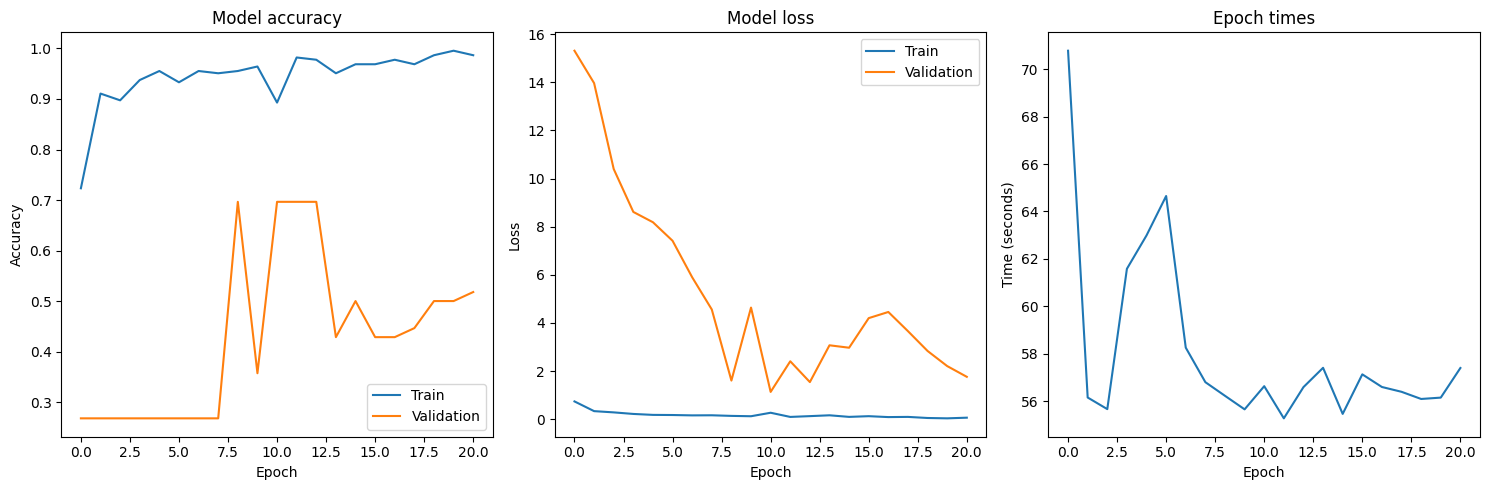

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Dense, GlobalAveragePooling3D
from tensorflow.keras.layers import Input, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import time
import os
from datetime import datetime

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
        self.epoch_times = []
        
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
        
    def on_epoch_end(self, epoch, logs={}):
        epoch_time = time.time() - self.epoch_time_start
        self.epoch_times.append(epoch_time)
        print(f'\nEpoch {epoch+1} took {epoch_time:.2f} seconds')

def preprocess_data(features, target_size=(160, 120)):
    """Resize features to reduce dimensionality"""
    processed_features = []
    for video in features:
        processed_frames = []
        for frame in video:
            resized_frame = tf.image.resize(frame, target_size)
            processed_frames.append(resized_frame)
        processed_features.append(processed_frames)
    return np.array(processed_features)

def create_flow_stream(input_shape, name='flow_stream'):
    """Creates an optimized optical flow stream using 3D CNN"""
    inputs = Input(shape=input_shape)
    
    # First block - reduced filter size
    x = Conv3D(32, kernel_size=(3, 5, 5), strides=(1, 2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling3D(pool_size=(1, 2, 2))(x)
    
    # Second block - reduced filter size
    x = Conv3D(64, kernel_size=(3, 3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    # Third block
    x = Conv3D(128, kernel_size=(3, 3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    # Global features
    x = GlobalAveragePooling3D()(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.5)(x)
    
    return Model(inputs=inputs, outputs=x, name=name)

def create_two_stream_model(input_shape, num_classes):
    flow_stream = create_flow_stream(input_shape)
    x = Dense(num_classes, activation='softmax')(flow_stream.output)
    return Model(inputs=flow_stream.input, outputs=x, name='two_stream_model')

def train_two_stream_model(features_train, labels_train, features_val, labels_val, input_shape, num_classes):
    # Create log directory
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(log_dir, exist_ok=True)
    
    # Create the model
    model = create_two_stream_model(input_shape, num_classes)
    
    # Compile with mixed precision
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    # Callbacks
    tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
    time_callback = TimeHistory()
    checkpoint = ModelCheckpoint(
        'best_two_stream_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    
    # Enable mixed precision training
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    
    # Train the model
    history = model.fit(
        features_train,
        labels_train,
        batch_size=16,  # Increased batch size
        epochs=50,      # Reduced epochs
        validation_data=(features_val, labels_val),
        callbacks=[checkpoint, early_stopping, reduce_lr, tensorboard, time_callback],
        verbose=1
    )
    
    return model, history, time_callback

# Preprocess and resize the data
print("Preprocessing data...")
target_size = (160, 120)  # Reduced dimensions
features_train2_processed = preprocess_data(features_train2, target_size)
features_val2_processed = preprocess_data(features_val2, target_size)
features_test2_processed = preprocess_data(features_test2, target_size)

print(f"Processed training data shape: {features_train2_processed.shape}")

# Updated input shape
input_shape = (20, target_size[0], target_size[1], 1)
num_classes = 3

# Print model summary
model = create_two_stream_model(input_shape, num_classes)
model.summary()

# Train the model
print("\nStarting training...")
model, history, time_callback = train_two_stream_model(
    features_train2_processed,
    labels_train2,
    features_val2_processed,
    labels_val2,
    input_shape,
    num_classes
)

# Print training time statistics
print("\nTraining time statistics:")
print(f"Average epoch time: {np.mean(time_callback.epoch_times):.2f} seconds")
print(f"Total training time: {sum(time_callback.epoch_times):.2f} seconds")

# Evaluate the model
print("\nEvaluating model...")
test_loss, test_accuracy = model.evaluate(features_test2_processed, labels_test2)
print(f"Test accuracy: {test_accuracy:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot training & validation accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot epoch times
plt.subplot(1, 3, 3)
plt.plot(time_callback.epoch_times)
plt.title('Epoch times')
plt.ylabel('Time (seconds)')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

Preprocessing data...
Starting preprocessing...
Processing video 1/224
Processing video 11/224
Processing video 21/224
Processing video 31/224
Processing video 41/224
Processing video 51/224
Processing video 61/224
Processing video 71/224
Processing video 81/224
Processing video 91/224
Processing video 101/224
Processing video 111/224
Processing video 121/224
Processing video 131/224
Processing video 141/224
Processing video 151/224
Processing video 161/224
Processing video 171/224
Processing video 181/224
Processing video 191/224
Processing video 201/224
Processing video 211/224
Processing video 221/224
Starting preprocessing...
Processing video 1/56
Processing video 11/56
Processing video 21/56
Processing video 31/56
Processing video 41/56
Processing video 51/56
Starting preprocessing...
Processing video 1/70
Processing video 11/70
Processing video 21/70
Processing video 31/70
Processing video 41/70
Processing video 51/70
Processing video 61/70
Processed training data shape: (224, 20

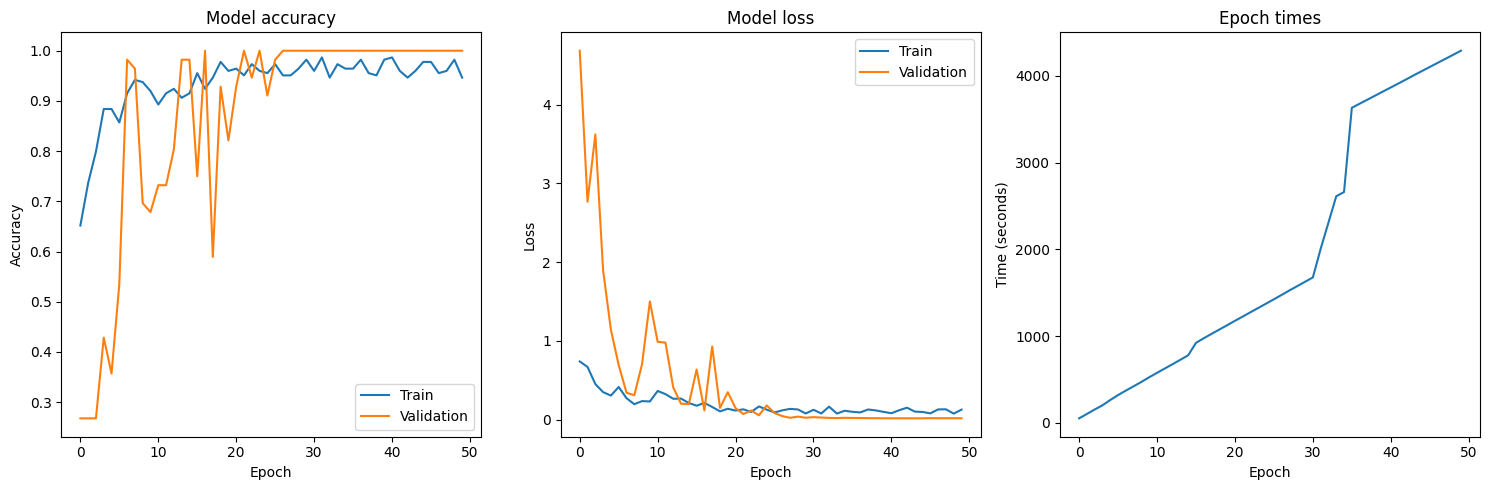

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Dense, GlobalAveragePooling3D
from tensorflow.keras.layers import Input, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import time
import os
from datetime import datetime
import numpy as np

def preprocess_data(features, target_size=(120, 90)):
    """Resize features to reduce dimensionality and ensure float32 dtype"""
    print("Starting preprocessing...")
    processed_features = []
    total = len(features)
    
    for i, video in enumerate(features):
        if i % 10 == 0:
            print(f"Processing video {i+1}/{total}")
        processed_frames = []
        for frame in video:
            # Ensure frame is float32
            frame = tf.cast(frame, tf.float32)
            resized_frame = tf.image.resize(frame, target_size)
            processed_frames.append(resized_frame)
        processed_features.append(processed_frames)
    
    # Convert to numpy array and ensure float32 dtype
    return np.array(processed_features, dtype=np.float32)

def create_optical_flow_model(input_shape, num_classes, name='optical_flow_model'):
    """Creates a 3D CNN model for optical flow processing with explicit float32 dtype"""
    inputs = Input(shape=input_shape, dtype=tf.float32)
    
    # First block
    x = Conv3D(16, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same', dtype=tf.float32)(inputs)
    x = BatchNormalization(dtype=tf.float32)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), dtype=tf.float32)(x)
    
    # Second block
    x = Conv3D(32, kernel_size=(3, 3, 3), padding='same', dtype=tf.float32)(x)
    x = BatchNormalization(dtype=tf.float32)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), dtype=tf.float32)(x)
    
    # Third block
    x = Conv3D(64, kernel_size=(3, 3, 3), padding='same', dtype=tf.float32)(x)
    x = BatchNormalization(dtype=tf.float32)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), dtype=tf.float32)(x)
    
    # Global features
    x = GlobalAveragePooling3D(dtype=tf.float32)(x)
    x = Dense(128, dtype=tf.float32)(x)
    x = BatchNormalization(dtype=tf.float32)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.5)(x)
    
    # Classification layer
    outputs = Dense(num_classes, activation='softmax', dtype=tf.float32)(x)
    
    model = Model(inputs=inputs, outputs=outputs, name=name)
    return model

def train_optical_flow_model(features_train, labels_train, features_val, labels_val, input_shape, num_classes):
    # Set mixed precision policy to float32
    tf.keras.mixed_precision.set_global_policy('float32')
    
    # Create log directory
    log_dir = "logs/optical_flow/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(log_dir, exist_ok=True)
    
    # Create and compile model
    model = create_optical_flow_model(input_shape, num_classes)
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    # Callbacks
    tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
    time_callback = TimeHistory()
    checkpoint = ModelCheckpoint(
        'best_optical_flow_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    
    # Train the model
    history = model.fit(
        features_train,
        labels_train,
        batch_size=8,
        epochs=50,
        validation_data=(features_val, labels_val),
        callbacks=[checkpoint, early_stopping, reduce_lr, tensorboard, time_callback],
        verbose=1
    )
    
    return model, history, time_callback
# Preprocess and resize the data
print("Preprocessing data...")
target_size = (120, 90)  # Further reduced dimensions
features_train2_processed = preprocess_data(features_train2, target_size)
features_val2_processed = preprocess_data(features_val2, target_size)
features_test2_processed = preprocess_data(features_test2, target_size)

print(f"Processed training data shape: {features_train2_processed.shape}")

# Set up model parameters
input_shape = (20, target_size[0], target_size[1], 1)
num_classes = 3

# Create and display model summary
model = create_optical_flow_model(input_shape, num_classes)
model.summary()

# Train the model
print("\nStarting training...")
model, history, time_callback = train_optical_flow_model(
    features_train2_processed,
    labels_train2,
    features_val2_processed,
    labels_val2,
    input_shape,
    num_classes
)

# Print training time statistics
print("\nTraining time statistics:")
print(f"Average epoch time: {np.mean(time_callback.times):.2f} seconds")
print(f"Total training time: {sum(time_callback.times):.2f} seconds")

# Evaluate the model
print("\nEvaluating model...")
test_loss, test_accuracy = model.evaluate(features_test2_processed, labels_test2)
print(f"Test accuracy: {test_accuracy:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot training & validation accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot epoch times
plt.subplot(1, 3, 3)
plt.plot(time_callback.times)
plt.title('Epoch times')
plt.ylabel('Time (seconds)')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

##### Display Architecture

In [33]:
two_stream_model = create_2stream_model()

print("Model Created Successfully!")

ValueError: Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 420)

## Train the Model

In [ ]:
# Train the model
create_model = two_stream_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = create_model.fit(
    [features_train1, features_train2], labels_train1,
    validation_data=([features_test1, features_test2], labels_test1),
    epochs=10, batch_size=16
)

In [ ]:
#save model
model_file_name = f'two_stream_ver1.h5'

two_stream_model.save(model_file_name)

## Evaluate Model